# Initialisation:
For each node 𝑖:
Load: 𝐿𝑖 = betweenness centrality of node 𝑖

Capacity: 𝐶𝑖 = (1+𝛼)*𝐿𝑖

where 𝛼 > 0 is a tolerance parameter.

A node fails if: 𝐿𝑖 > 𝐶𝑖

# First Attack:
Remove one node (e.g. Node 8, or highest-betweenness node)

# Cascade Dynamics:
Repeat until no new failures occur.

- Recompute betweenness on the remaining graph
- Update loads 𝐿𝑖
- Remove all nodes with 𝐿𝑖 > 𝐶𝑖

# Measure Damage:
Track:
- number of failed nodes
- size of largest connected component
- number of cascade steps

In [9]:
import networkx as nx
import numpy as np
import random

from cascade_failure.updated_model import load_data

G0 = load_data()
G0 = G0.copy()


# --------------------------------------------------
# Betweenness-based load and capacity initialization
# --------------------------------------------------
def initialize_betweenness_loads(G, alpha=0.2):
    bet = nx.betweenness_centrality(G, normalized=True)
    for n in G.nodes():
        G.nodes[n]["load"] = bet[n]
        G.nodes[n]["capacity"] = (1 + alpha) * bet[n]
        G.nodes[n]["failed"] = False

# def initialize_betweenness_loads(G):
#     bet=nx.betweenness_centrality(G, normalized=True)
#     for n in G.nodes():
#         capacity=bet[n]*random.uniform(10, 50)
#         load= capacity*random.uniform(0.1, 0.3)

#         G.nodes[n]['capacity']=capacity
#         G.nodes[n]['load']=load
#         G.nodes[n]['failed']=False

# --------------------------------------------------
# Cascading failure simulation
# --------------------------------------------------
def cascade_failure(G, initial_attack=None, verbose=False):
    G = G.copy()
    initialize_betweenness_loads(G)

    failed_nodes = set()
    step = 0

    lcc_history= []

    # Initial attack
    if initial_attack is not None:
        G.remove_node(initial_attack)
        failed_nodes.add(initial_attack)

    if G.number_of_nodes() > 0:
        lcc_history.append(len(max(nx.connected_components(G), key=len)))
    else:
        lcc_history.append(0)

    while True:
        step += 1
        bet = nx.betweenness_centrality(G, normalized=True)

        newly_failed = []
        for n in G.nodes():
            load = bet[n]
            capacity = G.nodes[n]["capacity"]
            if load > capacity:
                newly_failed.append(n)

        if not newly_failed:
            break

        if verbose:
            print(f"Step {step}: {len(newly_failed)} new failures")

        for n in newly_failed:
            G.remove_node(n)
            failed_nodes.add(n)

        if G.number_of_nodes() > 0:
            lcc_history.append(len(max(nx.connected_components(G), key=len)))
        else:
            lcc_history.append(0)

    # Metrics
    if G.number_of_nodes() > 0:
        largest_cc = len(max(nx.connected_components(G), key=len))
    else:
        largest_cc = 0

    return {
    "failed_nodes": failed_nodes,
    "num_failed": len(failed_nodes),
    "largest_cc": largest_cc,
    "remaining_nodes": G.number_of_nodes(),
    "steps": step,
    "lcc_history": lcc_history,
    "final_graph": G}


Graph loaded: 4941 nodes, 6594 edges


In [10]:
result_node8 = cascade_failure(
    G0,
    initial_attack=8,
    verbose=True
)

print(result_node8)

{'failed_nodes': {8}, 'num_failed': 1, 'largest_cc': 4938, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4938], 'final_graph': <networkx.classes.graph.Graph object at 0x0000014807D78FB0>}


In [11]:
# Highest betweenness node
bet = nx.betweenness_centrality(G0)
top_node = max(bet, key=bet.get)

result_top = cascade_failure(G0, initial_attack=top_node)
print(result_top)

{'failed_nodes': {0, 1, 4099, 2052, 5, 4101, 2054, 2051, 9, 4106, 11, 10, 13, 4110, 4111, 4112, 4113, 4114, 4115, 19, 20, 14, 4119, 2065, 4121, 26, 27, 2073, 29, 2074, 31, 32, 2079, 2080, 35, 36, 4132, 4133, 2086, 40, 41, 42, 2085, 2089, 2091, 46, 47, 4144, 4145, 48, 4146, 52, 4149, 54, 55, 2104, 57, 2099, 59, 60, 4156, 62, 2109, 2111, 4896, 2114, 2115, 4164, 2118, 71, 72, 73, 2120, 75, 4172, 4173, 77, 76, 80, 2126, 82, 83, 2130, 85, 86, 2127, 88, 2129, 2131, 4187, 92, 4188, 91, 95, 96, 97, 4194, 98, 100, 99, 2148, 103, 104, 105, 106, 4201, 4202, 109, 2150, 111, 2154, 113, 2158, 4211, 116, 4213, 4212, 4215, 120, 119, 4218, 123, 124, 4221, 125, 2176, 129, 130, 131, 4227, 2177, 134, 2179, 136, 2061, 138, 139, 140, 141, 2189, 143, 144, 145, 146, 147, 148, 2191, 150, 151, 2195, 2196, 155, 156, 2066, 2205, 2207, 2208, 161, 2213, 2214, 171, 172, 2221, 2222, 2223, 2219, 177, 178, 179, 2227, 181, 2230, 2225, 184, 185, 186, 2235, 2233, 189, 190, 4285, 191, 192, 193, 2238, 2242, 2241, 198, 199, 

In [12]:
# Random node
import random
rand_node = random.choice(list(G0.nodes()))
result_rand = cascade_failure(G0, initial_attack=rand_node)
print(result_rand)

{'failed_nodes': {1957}, 'num_failed': 1, 'largest_cc': 4940, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4940], 'final_graph': <networkx.classes.graph.Graph object at 0x00000148311EB4A0>}


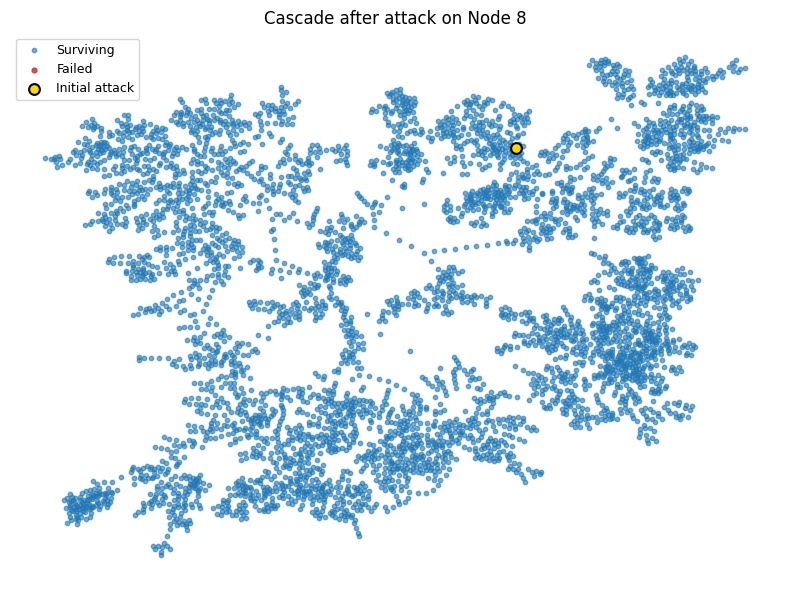

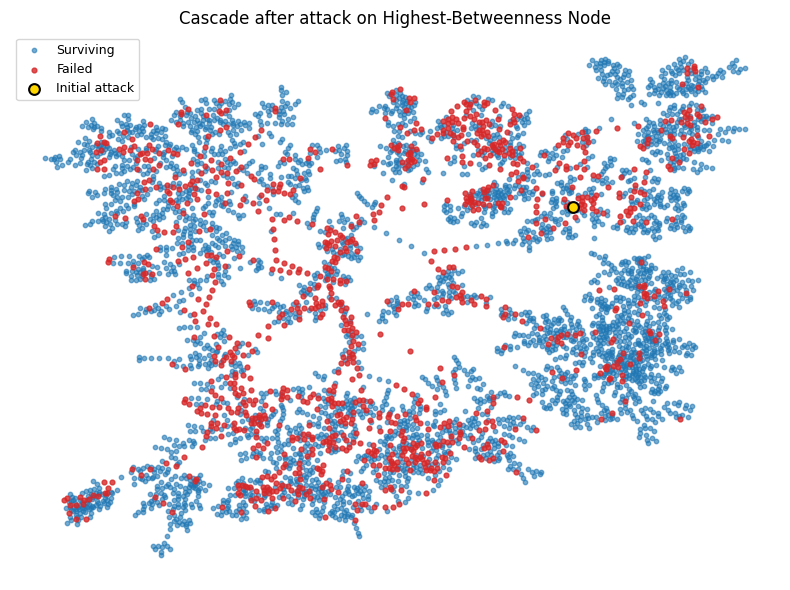

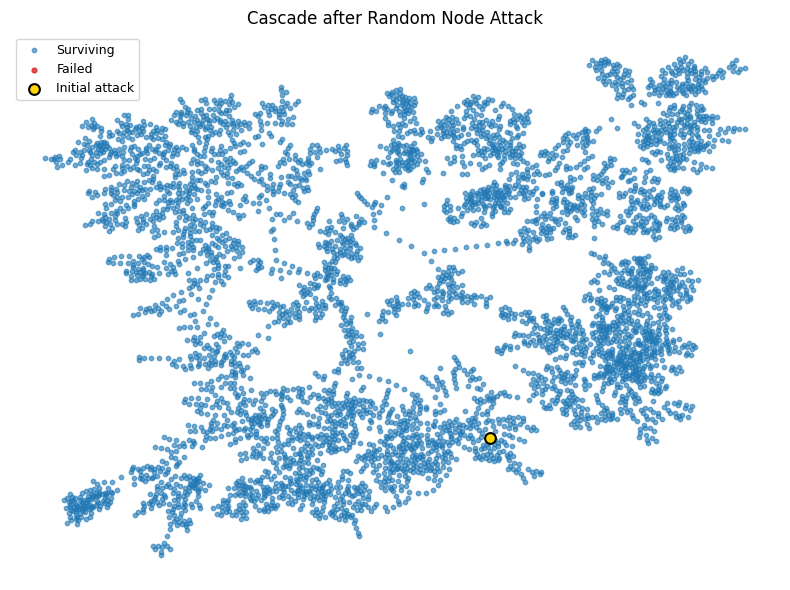

In [13]:
import matplotlib.pyplot as plt

def plot_cascade(G_original, result, title=None, attacked_node=None):
    G_final = result["final_graph"]
    failed = result["failed_nodes"]

    pos = nx.get_node_attributes(G_original, "pos")

    plt.figure(figsize=(8, 6))

    surviving = [n for n in G_final.nodes()]
    nx.draw_networkx_nodes(
        G_original,
        pos,
        nodelist=surviving,
        node_size=10,
        node_color="tab:blue",
        alpha=0.6,
        label="Surviving"
    )

    failed_existing = [n for n in failed if n in pos]
    nx.draw_networkx_nodes(
        G_original,
        pos,
        nodelist=failed_existing,
        node_size=12,
        node_color="tab:red",
        alpha=0.8,
        label="Failed"
    )

    if attacked_node is not None and attacked_node in pos:
        nx.draw_networkx_nodes(
            G_original,
            pos,
            nodelist=[attacked_node],
            node_size=60,
            node_color="gold",
            edgecolors="black",
            linewidths=1.5,
            label="Initial attack"
        )

    plt.title(title or "Cascading Failure Outcome")
    plt.axis("off")
    plt.legend(scatterpoints=1, fontsize=9)
    plt.tight_layout()
    plt.show()

# Node 8 attack
plot_cascade(
    G0,
    result_node8,
    title="Cascade after attack on Node 8",
    attacked_node=8
)

# Highest-betweenness attack
plot_cascade(
    G0,
    result_top,
    title="Cascade after attack on Highest-Betweenness Node",
    attacked_node=top_node
)

# Random node attack
plot_cascade(
    G0,
    result_rand,
    title="Cascade after Random Node Attack",
    attacked_node=rand_node
)

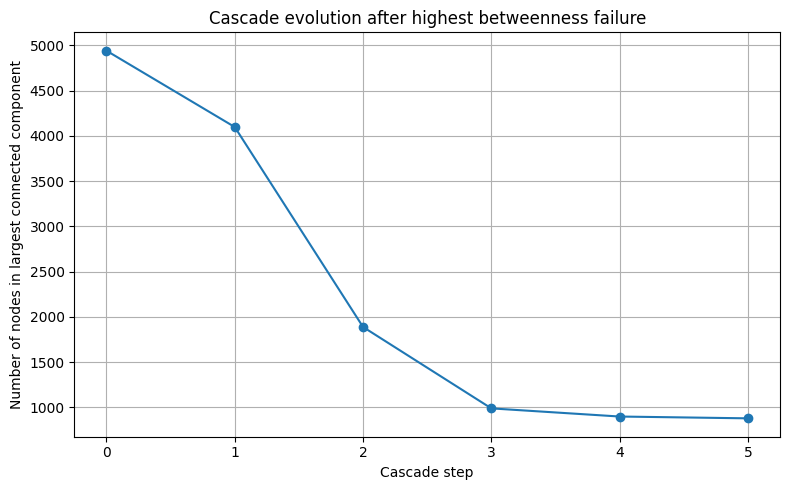

In [14]:
import matplotlib.pyplot as plt
lcc=result_top["lcc_history"]
steps=range(len(lcc))

plt.figure(figsize=(8,5))
plt.plot(steps, lcc, marker='o')
plt.xlabel("Cascade step")
plt.ylabel("Number of nodes in largest connected component")
plt.title("Cascade evolution after highest betweenness failure")
plt.grid(True)
plt.tight_layout()
plt.show()

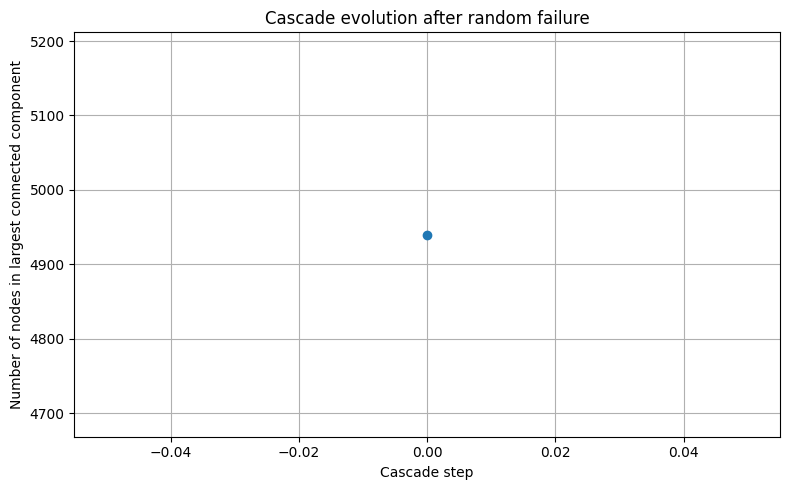

In [15]:
lcc_rand=result_rand["lcc_history"]
steps_rand=range(len(lcc_rand))

plt.figure(figsize=(8,5))
plt.plot(steps_rand, lcc_rand, marker='o')
plt.xlabel("Cascade step")
plt.ylabel("Number of nodes in largest connected component")
plt.title("Cascade evolution after random failure")
plt.grid(True)
plt.tight_layout()
plt.show()